# PetFinder.my - Un approccio Ibrido

In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, concatenate
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pylab as pl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
path = '../input/petfinder-pawpularity-score'
training_dir = path + '/train'
test_dir = path + '/test'

df_train = pd.read_csv(path + '/train.csv')
df_test = pd.read_csv(path + '/test.csv')
df_train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


# Data Exploration

In [3]:
def plot_imgs(item_dir, num_imgs=5, cmap='viridis'):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

  plt.figure(figsize=(20, 20))
  for idx, img_path in enumerate(item_files):
    img_df = df_train.sample()
    img_id = img_df['Id'].values[0]
    img = plt.imread(f'{training_dir}/{img_id}.jpg')

    plt.subplot(5, 5, idx+1)
    plt.title(f'Pawpularity: {img_df["Pawpularity"].values[0]}')
    plt.axis('off')
    plt.imshow(img)

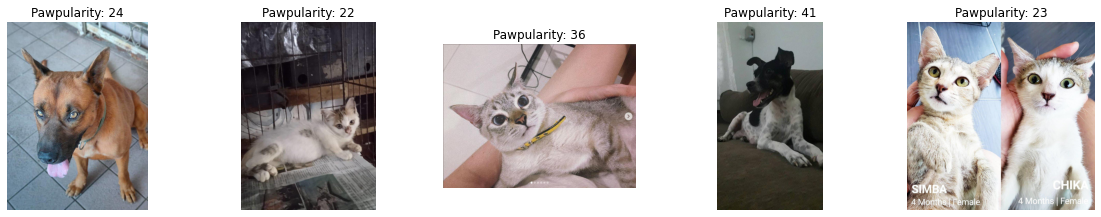

In [4]:
plot_imgs(training_dir)

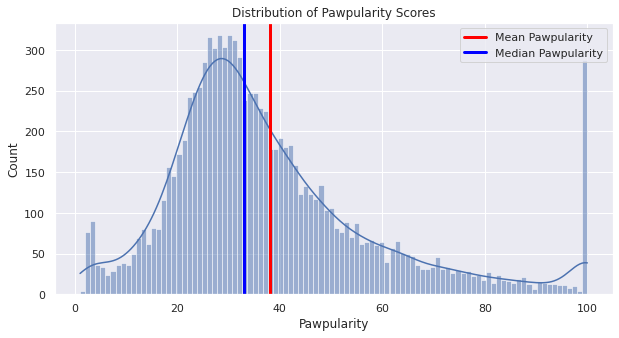

In [5]:
sns.set(rc={'figure.figsize':(10,5)})
fig = plt.figure()
sns.histplot(data=df_train, x='Pawpularity', bins=100, kde=True)
plt.axvline(df_train['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(df_train['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores')
plt.legend()
plt.show()

In [6]:
def plot_feature_img(label):
  fig, ax = plt.subplots(1, 3, figsize=(15, 4))
  count = df_train[label].value_counts().sort_values()

  for i in [1, 0]:
    img_id = df_train[df_train[label] == i].sample()['Id'].values[0]
    img = plt.imread(f'{training_dir}/{img_id}.jpg')
    c = 1 if i == 1 else 2
    ax[c].imshow(img)
    ax[c].set_title(f'{label}={i}')
    ax[c].axis('off')
  sns.histplot(df_train, x="Pawpularity", hue=label, kde=True, ax=ax[0])
  ax[0].set_title(f'Distribution of {label}')
  fig.show()

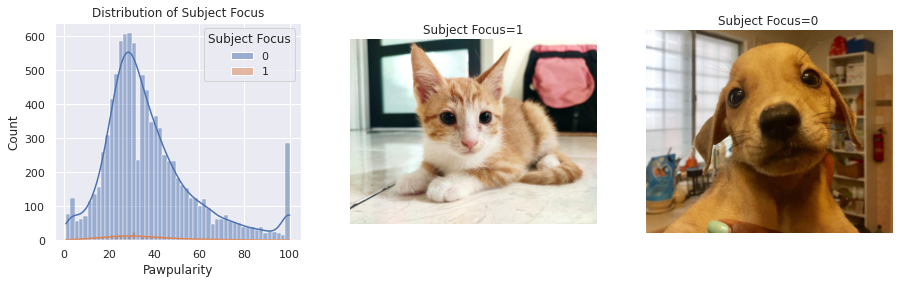

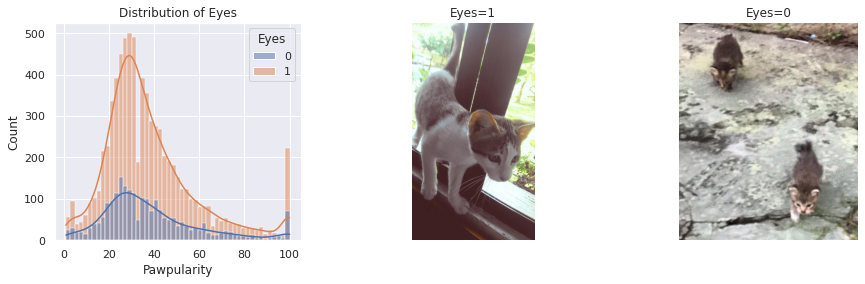

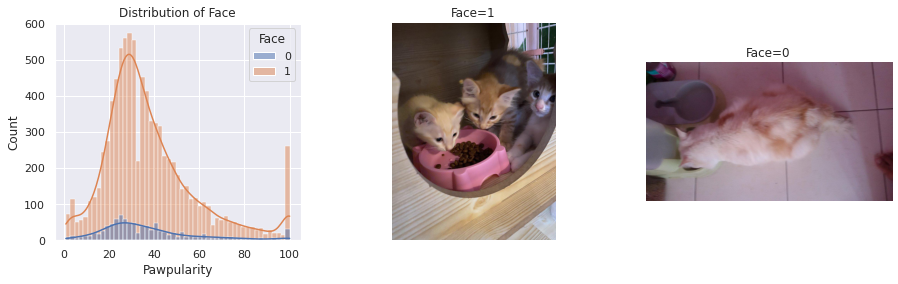

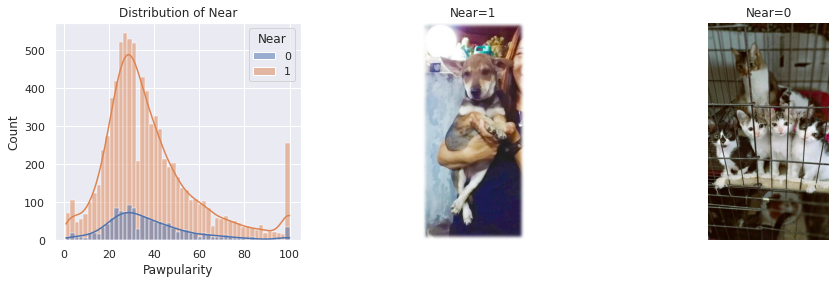

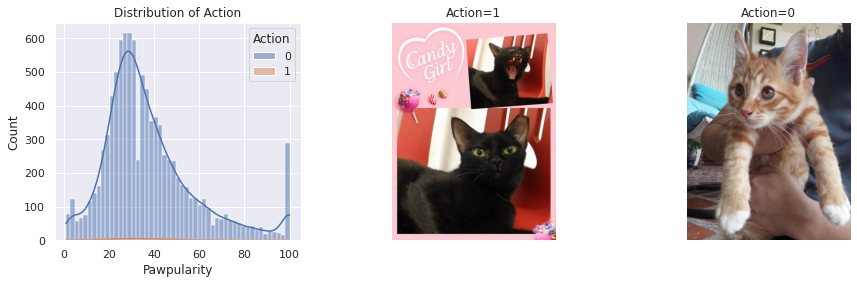

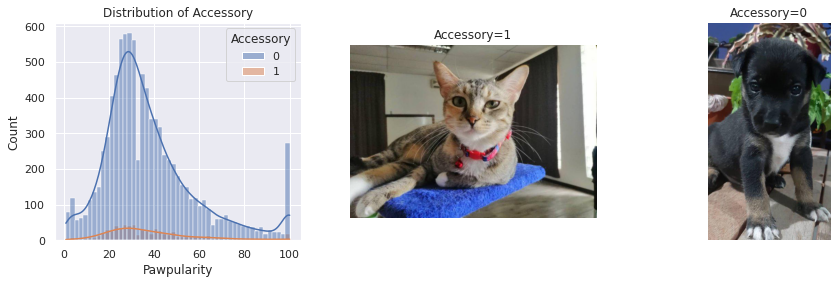

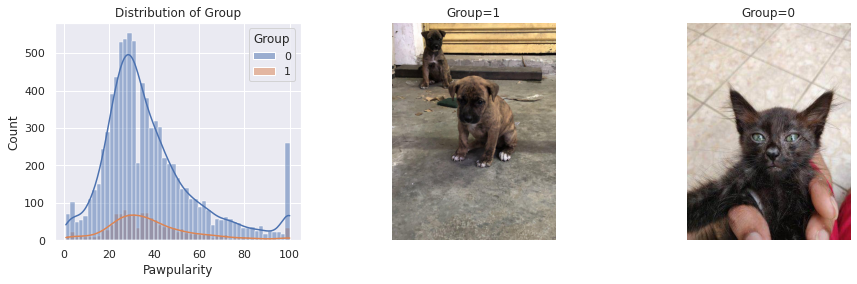

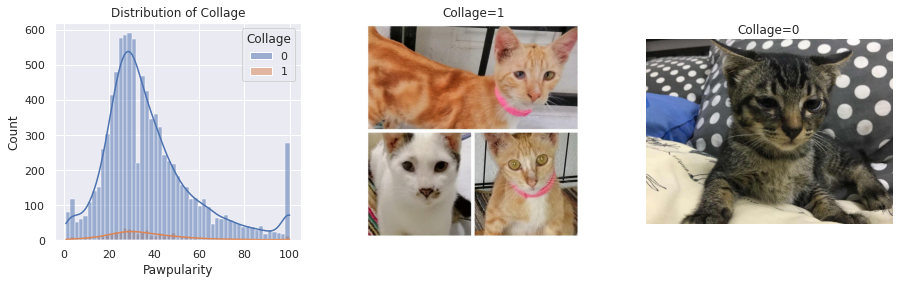

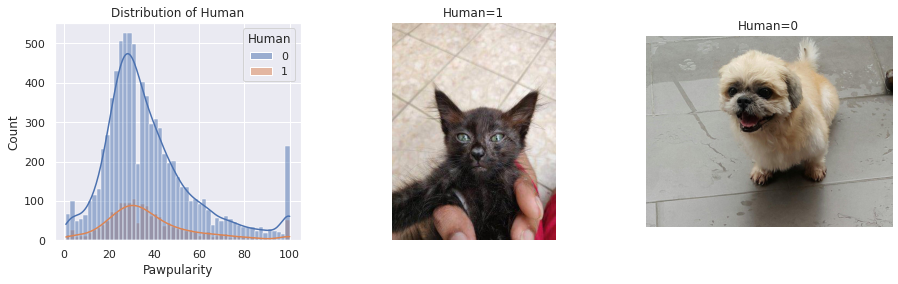

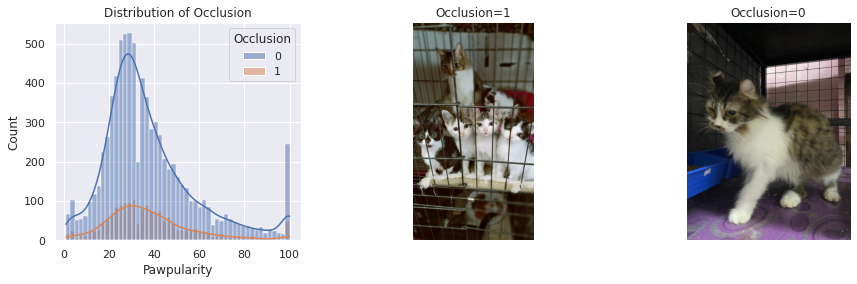

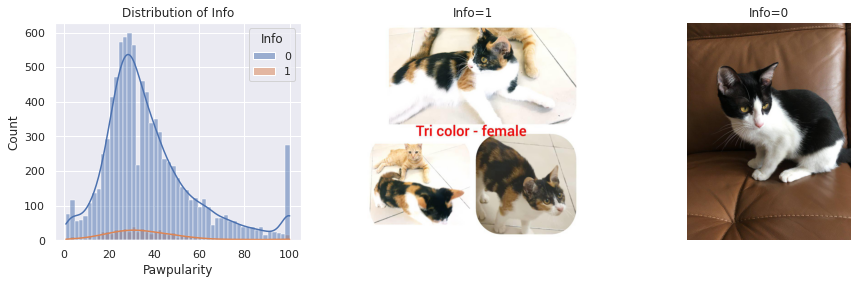

In [7]:
for i in range(1, 12):
  label = df_train.columns[i]
  plot_feature_img(label)

In [8]:
# Load the images and the labels
train_imgs = []
for img in sorted(os.listdir(path + '/train')):
    pic = image.load_img((path + '/train/' + img), target_size=(300, 300))
    train_imgs.append(np.array(pic))

In [9]:
# Load test images
test_imgs = []
for img in sorted(os.listdir(path + '/test')):
    pic = image.load_img((path + '/test/' + img), target_size=(300, 300))
    test_imgs.append(np.array(pic))

In [10]:
# Train labels

Y = np.array(df_train['Pawpularity'])

df_train.drop('Pawpularity', axis=1, inplace=True)
df_train.drop('Id', axis=1, inplace=True)

# Images Train and validation split 
x_train, x_val, y_train, y_val = train_test_split(train_imgs, Y, test_size=0.1, random_state=11)

# Dataframe train and validation split
df_x_train, df_x_val, df_y_train, df_y_val = train_test_split(df_train, Y, test_size=0.1, random_state=11)

# CNN

Convolutional Neural Network. Si effettua fine-tuning della rete EfficientNetB3 con pesi ottenuti tramite tecnica di training NoisyStudent. La CNN è collegata ad una rete fully-connected con questa architettura:
- Dense - 1024 neuroni, ReLU
- Dropout - 50% dei neuroni eliminati.
- Dense - 512 neuroni, ReLU
- Dropout - 30% dei neuroni eliminati.
- Dense - 128 neuroni, ReLU
- Dropout - 10% dei neuroni eliminati.
- Dense - 1 neurone, Linear

L'algoritmo di ottimizzazione scelto è Adam. Per il calcolo della loss si utilizza MSE e come metrica di performance RMSE.
Si salvano i pesi tramite checkpoint e si utilizzano quelli che ottengono un valore migliore nel validation loss.

In [11]:
# Load a pre-trained neural network to use for transfer learning
base_net = keras.applications.EfficientNetB3(
    input_shape=(300,300,3),
    weights='../input/noisystudentkeras/noisystudent_efficientnetb3_notop.h5',
    include_top=False,
    drop_connect_rate=0.4,
    pooling='avg'
)

# Set the layers of the base net to not be trained
for layer in base_net.layers:
  layer.trainable=False

2022-01-20 20:16:35.042232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:16:35.126457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:16:35.127174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:16:35.128299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
x = Flatten()(base_net.layers[-1].output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1, activation='linear')(x)
outputs = x

OPT = tf.keras.optimizers.Adam()

cnn = keras.Model(inputs=base_net.inputs, outputs=outputs)
cnn.compile(loss='mean_squared_error', optimizer=OPT, metrics=['RootMeanSquaredError'])

In [13]:
filepath_cnn="weights.cnn.hdf5"
checkpoint = ModelCheckpoint(filepath_cnn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [14]:
hist_cnn = cnn.fit(np.array(x_train), y_train, epochs=30, validation_data=(np.array(x_val), y_val),
                   callbacks=[checkpoint])

cnn.load_weights(filepath_cnn)

for layer in cnn.layers:
  layer.trainable=False

2022-01-20 20:16:42.448147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2408400000 exceeds 10% of free system memory.
2022-01-20 20:16:44.856214: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2408400000 exceeds 10% of free system memory.
2022-01-20 20:16:46.610772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-20 20:16:55.171943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


279/279 [==============================] - 55s 149ms/step - loss: 440.9592 - root_mean_squared_error: 20.9990 - val_loss: 340.4442 - val_root_mean_squared_error: 18.4511

Epoch 00001: val_loss improved from inf to 340.44424, saving model to weights.cnn.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
279/279 [==============================] - 37s 132ms/step - loss: 375.7235 - root_mean_squared_error: 19.3836 - val_loss: 325.8520 - val_root_mean_squared_error: 18.0514

Epoch 00002: val_loss improved from 340.44424 to 325.85196, saving model to weights.cnn.hdf5
Epoch 3/30
279/279 [==============================] - 37s 133ms/step - loss: 369.1348 - root_mean_squared_error: 19.2129 - val_loss: 320.4664 - val_root_mean_squared_error: 17.9016

Epoch 00003: val_loss improved from 325.85196 to 320.46643, saving model to weights.cnn.hdf5
Epoch 4/30
279/279 [==============================] - 37s 133ms/step - loss: 353.5964 - root_mean_squared_error: 18.8042 - val_loss: 313.1474 - val_root_mean_squared_error: 17.6960

Epoch 00004: val_loss improved from 320.46643 to 313.14737, saving model to weights.cnn.hdf5
Epoch 5/30
279/279 [==============================] - 39s 139ms/step - loss: 346.3271 - root_mean_squared_error: 18.6099 - val_loss: 333.8764 - val_root_mean_squared_error: 18

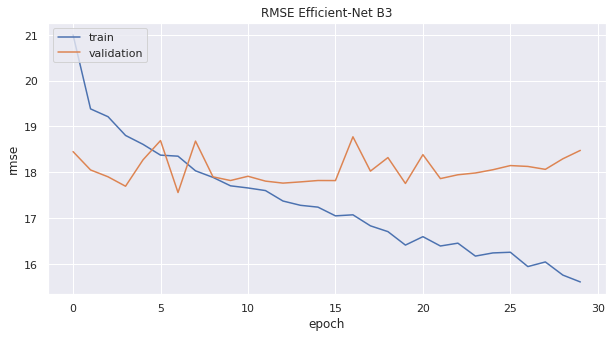

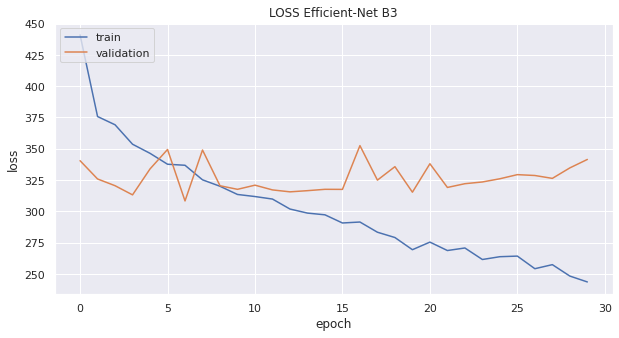

In [15]:

def plot_hist(hist, title):
    plt.plot(hist.history["root_mean_squared_error"])
    plt.plot(hist.history["val_root_mean_squared_error"])
    plt.title("RMSE " + title)
    plt.ylabel("rmse")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


plot_hist(hist_cnn, title="Efficient-Net B3")

# MLP

Per trattare i metadati riguardati le foto, si è deciso di utilizzare una rete
neurale classica fully-connected. Di seguito viene riportata l’architettura del
modello:
- Dense - 32 neuroni, ReLU
- Dropout - 20% dei neuroni eliminati.
- Dense - 8 neuroni, ReLU
- Dropout - 10% dei neuroni eliminati.
- Dense - 1 neurone, Linear

Anche in questo caso, come per la rete convoluzionale, si sono utilizzate
MSE come funzione di loss, RMSE come metrica delle performance del
modello e Adam come algoritmo di ottimizzazione.

In [16]:
dims = df_x_train.shape[1]

mlp = Sequential()
mlp.add(Dense(32, activation='relu', input_shape=(dims,)))
mlp.add(Dropout(0.2))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dropout(0.1))
mlp.add(Dense(1, activation="linear"))


# compile: optimizer & losses/metrics
mlp.compile(loss='mean_squared_error', optimizer=OPT, metrics=['RootMeanSquaredError'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [17]:
filepath_mlp="weights.mlp.hdf5"
checkpoint = ModelCheckpoint(filepath_mlp, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [18]:
hist_FC = mlp.fit(df_x_train, df_y_train, epochs=30, batch_size=32, validation_data=(df_x_val, df_y_val), 
                  callbacks=[checkpoint])


mlp.load_weights(filepath_mlp)

for layer in mlp.layers:
  layer.trainable=False

Epoch 1/30
279/279 [==============================] - 1s 3ms/step - loss: 671.6057 - root_mean_squared_error: 25.9154 - val_loss: 428.6799 - val_root_mean_squared_error: 20.7046

Epoch 00001: val_loss improved from inf to 428.67987, saving model to weights.mlp.hdf5
Epoch 2/30
279/279 [==============================] - 1s 3ms/step - loss: 492.9256 - root_mean_squared_error: 22.2019 - val_loss: 418.0474 - val_root_mean_squared_error: 20.4462

Epoch 00002: val_loss improved from 428.67987 to 418.04742, saving model to weights.mlp.hdf5
Epoch 3/30
279/279 [==============================] - 1s 3ms/step - loss: 480.1154 - root_mean_squared_error: 21.9115 - val_loss: 412.6497 - val_root_mean_squared_error: 20.3138

Epoch 00003: val_loss improved from 418.04742 to 412.64975, saving model to weights.mlp.hdf5
Epoch 4/30
279/279 [==============================] - 1s 2ms/step - loss: 470.9495 - root_mean_squared_error: 21.7014 - val_loss: 411.4318 - val_root_mean_squared_error: 20.2838

Epoch 00004

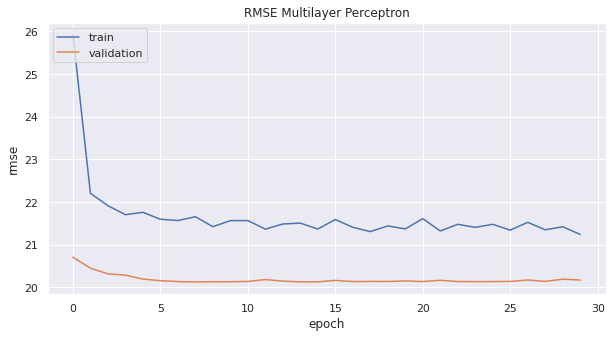

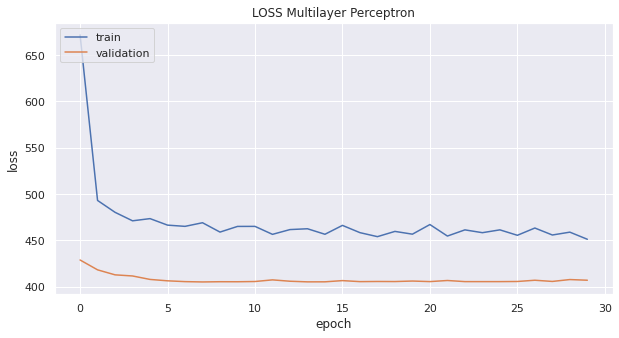

In [19]:
plot_hist(hist_FC, title="Multilayer Perceptron")

# Hybrid Deep Neural Network

Il modello in questione si presenta come una rete ibrida, ovvero l'unione delle due reti precedentemente create. Si aggiunge, per processare gli output dei due modelli utilizzati, una rete fully-connected con queste caratteristiche:

- Dense - 2 neuroni, ReLU
- Dense - 1 neuroni, Linear

Anche in questo caso si sono utilizzate
MSE come funzione di loss, RMSE come metrica delle performance del
modello e Adam come algoritmo di ottimizzazione.


In [20]:
combined = concatenate([mlp.output, cnn.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
model = Model(inputs=[mlp.input, cnn.input], outputs=z)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
filepath_hybrid="weights.hybrid.hdf5"
checkpoint = ModelCheckpoint(filepath_hybrid, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



# train the model
hist = model.fit(x=[df_x_train, np.array(x_train)], 
          y=y_train, 
          epochs=30, 
          batch_size=32, 
          validation_data=([df_x_val, np.array(x_val)], y_val),  
          callbacks=[checkpoint])

model.load_weights(filepath_hybrid)


2022-01-20 20:37:45.021816: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2408400000 exceeds 10% of free system memory.
2022-01-20 20:37:47.521114: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2408400000 exceeds 10% of free system memory.


Epoch 1/30
279/279 [==============================] - 49s 149ms/step - loss: 1556.6350 - root_mean_squared_error: 39.4542 - val_loss: 845.4036 - val_root_mean_squared_error: 29.0758

Epoch 00001: val_loss improved from inf to 845.40356, saving model to weights.hybrid.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
279/279 [==============================] - 37s 134ms/step - loss: 487.2139 - root_mean_squared_error: 22.0729 - val_loss: 317.7754 - val_root_mean_squared_error: 17.8263

Epoch 00002: val_loss improved from 845.40356 to 317.77539, saving model to weights.hybrid.hdf5
Epoch 3/30
279/279 [==============================] - 37s 134ms/step - loss: 322.2922 - root_mean_squared_error: 17.9525 - val_loss: 310.6003 - val_root_mean_squared_error: 17.6239

Epoch 00003: val_loss improved from 317.77539 to 310.60028, saving model to weights.hybrid.hdf5
Epoch 4/30
279/279 [==============================] - 39s 141ms/step - loss: 317.8722 - root_mean_squared_error: 17.8290 - val_loss: 308.2870 - val_root_mean_squared_error: 17.5581

Epoch 00004: val_loss improved from 310.60028 to 308.28699, saving model to weights.hybrid.hdf5
Epoch 5/30
279/279 [==============================] - 37s 134ms/step - loss: 317.7050 - root_mean_squared_error: 17.8243 - val_loss: 306.0732 - val_root_mean_squared_

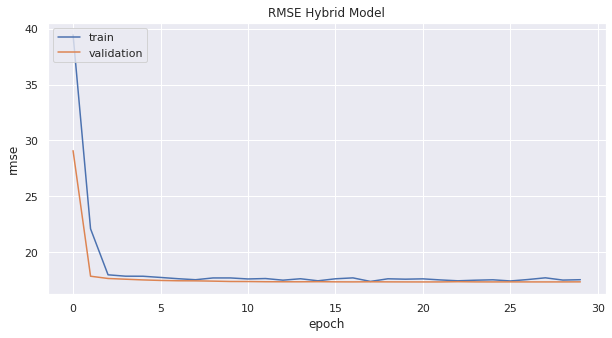

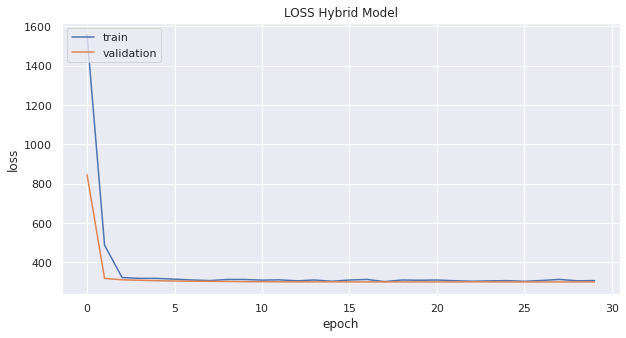

In [22]:
plot_hist(hist, title="Hybrid Model")

# Submission

Si effettua la submission del modello finale.

In [23]:
df_x_test = df_test.loc[:,'Subject Focus':'Blur']
pred = model.predict([df_x_test, np.array(test_imgs)])
submission = pd.DataFrame(df_test['Id'])
submission['Pawpularity'] = pred
submission.to_csv('submission.csv', index=False)

In [24]:
submission.head(5)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,30.986450
1,43a2262d7738e3d420d453815151079e,31.294153
2,4e429cead1848a298432a0acad014c9d,31.364992
3,80bc3ccafcc51b66303c2c263aa38486,34.360046
4,8f49844c382931444e68dffbe20228f4,35.387806


# Models performance

Si mostrano le performance dei modelli a confronto.

In [25]:
loss_cnn = min(hist_cnn.history['val_loss'])
rmse_cnn = min(hist_cnn.history['val_root_mean_squared_error'])
print("validation loss CNN model:", loss_cnn)
print("validation rmse CNN model:", rmse_cnn)

print('\n-----------------------------------\n')

loss_mlp = min(hist_FC.history['val_loss'])
rmse_mlp = min(hist_FC.history['val_root_mean_squared_error'])
print("validation loss MLP model:", loss_mlp)
print("validation rmse MLP model:", rmse_mlp)

print('\n-----------------------------------\n')

loss_final = min(hist.history['val_loss'])
rmse_final = min(hist.history['val_root_mean_squared_error'])
print("validation loss hybrid model:", loss_final)
print("validation rmse hybrid model:", rmse_final)

validation loss CNN model: 308.3062744140625
validation rmse CNN model: 17.558652877807617

-----------------------------------

validation loss MLP model: 404.9841003417969
validation rmse MLP model: 20.124216079711914

-----------------------------------

validation loss hybrid model: 299.7429504394531
validation rmse hybrid model: 17.313085556030273


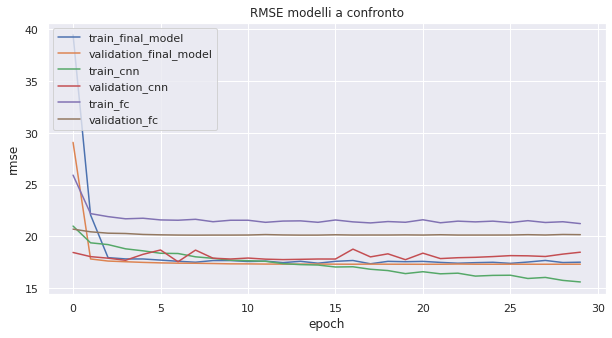

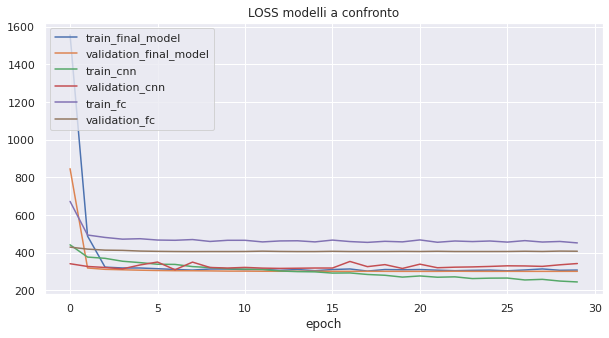

In [26]:
plt.plot(hist.history["root_mean_squared_error"])
plt.plot(hist.history["val_root_mean_squared_error"])
plt.plot(hist_cnn.history["root_mean_squared_error"])
plt.plot(hist_cnn.history["val_root_mean_squared_error"])
plt.plot(hist_FC.history["root_mean_squared_error"])
plt.plot(hist_FC.history["val_root_mean_squared_error"])
plt.title("RMSE modelli a confronto")
plt.ylabel("rmse")
plt.xlabel("epoch")
plt.legend(["train_final_model", "validation_final_model", "train_cnn", "validation_cnn","train_fc", "validation_fc"], loc="upper left")
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.plot(hist_FC.history['loss'])
plt.plot(hist_FC.history['val_loss'])
plt.title("LOSS modelli a confronto")
plt.xlabel('epoch')
plt.legend(["train_final_model", "validation_final_model", "train_cnn", "validation_cnn","train_fc", "validation_fc"], loc='upper left')
plt.show()

# Grad CAM

Per analizzare i
risultati ottenuti è stato ritenuto opportuno effettuare un ulteriore studio su
come la rete convoluzionale ragionasse sulle immagini per ottenere lo score di
popolarità.

In [27]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap
    


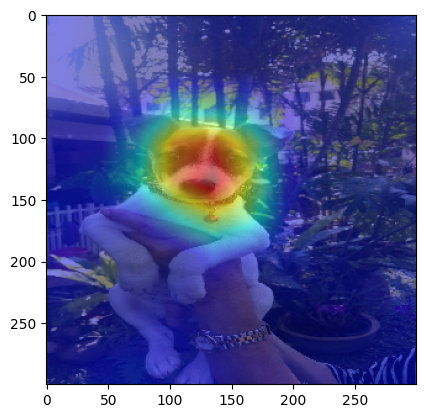

In [28]:
plt.style.use('default')


test_img1 = img_to_array(load_img("../input/petfinder-pawpularity-score/train/07d7a049edcc636e91cd461cbd762234.jpg" , target_size=(300,300)))

# Plot features extracted
VizGradCAM(cnn, test_img1)